In [1]:
import pandas as pd
from pandas import DataFrame, Series
#false positive warnings all the time:
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import statistics

import os.path

from sklearn import tree
import graphviz 

In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

In [3]:
def generateSimulationID(tup):
    identifier = tup[0] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + tup[3] \
            + "_" + tup[4] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra


simulation_map = {
    "Watdiv10M": "W10", "Watdiv100M": "W100", "Watdiv1000M": "W1000", "Ontoforce": "Ont"
}

def generateSimulationIDCompact(tup, pref_length=3):
    #pref_length = 3
    identifier = tup[0][:pref_length] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + simulation_map[tup[3]] \
            + "_" + str(tup[4])[:pref_length] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra

In [4]:
def generateFilenameQueryEventsCorrect(bmtuple):
    fname = './csv_correct/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents_correct.csv"

In [5]:
def convertflag(flag):
    if flag == 'SUCCESS':
        return 0
    elif flag == 'ERROR':
        return 1
    else: #timeout
        return 2

def convertcorrect(c):
    if c == 'CORRECT':
        return 1
    elif c == 'INCORRECT':
        return 0
    else:
        return 1

In [6]:
query_features = './OntoforceQueryAnalysis/ontoforce_query_features.tsv'
df_queryfeatures = pd.read_csv(query_features, sep='\t', index_col=0)
df_queryfeatures.head(n=3)

,order,filter_in,limit,distinct,triplePattern,tp_?po,union,tp_?p?,aggregation_count,tp_sp?,...,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
xaa,0.0,2.0,0.0,1.0,14.0,0.0,1.0,8.0,1.0,0.0,...,0.0,1.0,49.0,13.0,6.0,0.0,3.0,313.0,10373.0,5.0
xab,1.0,1.0,1.0,1.0,5.0,0.0,0.0,3.0,1.0,0.0,...,0.0,2.0,35.0,5.0,2.0,0.0,2.0,180.0,4114.0,4.0
xac,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,7.0,0.0,0.0,0.0,1.0,26.0,609.0,2.0


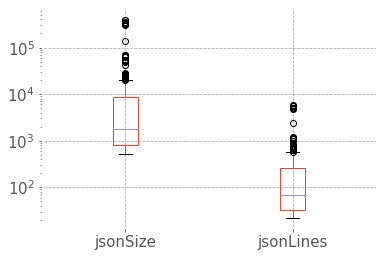

In [7]:
df_queryfeatures[['jsonSize', 'jsonLines']].plot(kind='box', logy=True)

In [8]:
### jsonSize > 10kb is a turning point and jsonSize > 100kb another one
def map_size(s):
    if s < 1e4:
        return 1
    elif s < 1e5: #10k
        return 10
    else:
        return 100 #100k
df_queryfeatures['jsonSize'] = df_queryfeatures['jsonSize'].apply(map_size)

# 1. Generate DF per simulation

### Create classes

    - 3: success   = 3 * correct(=1)   + success(=0)  = 3
    - 1: error     = 3 * incorrect(=0) + error(=1)
    - 2: timeout   = 3 * incorrect(=0) + timeout(=2)
    - 0: incorrect = 3 * incorrect(=0) + success(=0) = 0

#### Additional time classes: 

    - 3: <1s
    - 4: <10s
    - 5: <100s
    - 6: >=100s
    

### Tryout

In [9]:
def convert_time(t):
    if t<1.0:
        return 0
    elif t<10.0:
        return 1
    elif t<100.0:
        return 2
    else:
        return 3
    
all_classnames =['#incorrect', '#http error', '#timeout', '#<1s', '#<10s', '#<100s', '#>100s']
all_classnames    
    

['#incorrect', '#http error', '#timeout', '#<1s', '#<10s', '#<100s', '#>100s']

In [10]:
tuple_list = [('Blazegraph', 1, 64, 'Ontoforce', 'Optimized', ''), \
              ('ES', 1, 64, 'Ontoforce', 'Default', ''), \
              ('GraphDB', 1, 64, 'Ontoforce', 'Optimized', ''), \
              ('Virtuoso', 1, 64, 'Ontoforce', 'Optimized', ''), \
              ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', 'VWall'), \
              ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '0'), \
              ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '2') \
             ]

In [11]:
tup = tuple_list[0]

filename = generateFilenameQueryEventsCorrect(tup)
df = pd.read_csv(filename, sep='\t')
df.index = df['query_name'].apply(lambda q: q[8:]).values
df = df.dropna()
print(df.shape)

#clean up data 
#REVISON: Keep: , jsonSize

df2 = df.drop(['sim_id', 'query_name', 'thread_type', 'number_of_results', 'thread_id', 'order_id'],axis=1)
df2['flag2'] = df2['flag'].apply(convertflag)
df2['correct2'] = df2['correct'].apply(convertcorrect)
df2['class'] = 3*df2['correct2'] + df2['flag2'] 
df3 = df2.drop(['flag', 'correct', 'flag2', 'correct2'],axis=1)
df4 = df3.join(df_queryfeatures)

interesting_cols = ['class', 'runtime', 'group', 'optional', 'order', 'filter_in', 'filter', 
       'aggregation_count', 'graph', 'triplePattern', 'query', 'jsonSize']

df5 = df4[interesting_cols]

(468, 9)


In [12]:
df5['runtime_magnitude'] = df5['runtime'].apply(convert_time)
df6 = df5.drop('runtime', axis=1)
df6.loc[df6['class'] ==3, 'class'] = df6.loc[df6['class'] ==3, 'class'] + df6.loc[df6['class'] ==3, 'runtime_magnitude']
df7 = df6.drop('runtime_magnitude', axis=1)
df7['class'].value_counts()

2    431
3     18
5      8
6      7
4      3
0      1
Name: class, dtype: int64

In [13]:
def generate_query_classification_DF(tup):
    print(generateSimulationIDCompact(tup))
    filename = generateFilenameQueryEventsCorrect(tup)
    df = pd.read_csv(filename, sep='\t')
    df.index = df['query_name'].apply(lambda q: q[8:]).values
    df = df.dropna()
    print("Number of queries: " + str(df.shape[0]))
    #
    df2 = df.drop(['sim_id', 'query_name', 'thread_type', 'number_of_results',  'thread_id', 'order_id'],axis=1)
    df2['flag2'] = df2['flag'].apply(convertflag)
    df2['correct2'] = df2['correct'].apply(convertcorrect)
    df2['class'] = 3*df2['correct2'] + df2['flag2'] 
    df3 = df2.drop(['flag', 'correct', 'flag2', 'correct2'],axis=1)
    df4 = df3.join(df_queryfeatures)

    #added jsonsize
    interesting_cols = ['class', 'runtime', 'group', 'optional', 'order', 'filter_in', 'filter', 
           'aggregation_count', 'graph', 'triplePattern', 'query', 'jsonSize']

    df5 = df4[interesting_cols]
    df5['runtime_magnitude'] = df5['runtime'].apply(convert_time)
    df6 = df5.drop('runtime', axis=1)
    df6.loc[df6['class'] ==3, 'class'] = df6.loc[df6['class'] ==3, 'class'] + df6.loc[df6['class'] ==3, 'runtime_magnitude']
    df7 = df6.drop('runtime_magnitude', axis=1)
    return df7.rename(columns={'aggregation_count': 'count'})
    

    
def generate_query_classification_and_runtime_DF(tup):
    print(generateSimulationIDCompact(tup))
    filename = generateFilenameQueryEventsCorrect(tup)
    df = pd.read_csv(filename, sep='\t')
    df.index = df['query_name'].apply(lambda q: q[8:]).values
    df = df.dropna()
    print("Number of queries: " + str(df.shape[0]))
    
    df2 = df.drop(['sim_id', 'query_name', 'thread_type', 'number_of_results', 'thread_id', 'order_id'],axis=1)
    df2['flag2'] = df2['flag'].apply(convertflag)
    df2['correct2'] = df2['correct'].apply(convertcorrect)
    df2['class'] = 3*df2['correct2'] + df2['flag2'] 
    df3 = df2.drop(['flag', 'correct', 'flag2', 'correct2'],axis=1)
    df4 = df3.join(df_queryfeatures)

    interesting_cols = ['class', 'runtime', 'group', 'optional', 'order', 'filter_in', 'filter', 
           'aggregation_count', 'graph', 'triplePattern', 'query', 'jsonSize']

    df5 = df4[interesting_cols]
    df5['runtime_magnitude'] = df5['runtime'].apply(convert_time)
    df6 = df5
    df6.loc[df6['class'] ==3, 'class'] = df6.loc[df6['class'] ==3, 'class'] + df6.loc[df6['class'] ==3, 'runtime_magnitude']
    df7 = df6.drop('runtime_magnitude', axis=1)
    return df7.rename(columns={'aggregation_count': 'count'})    
    

In [14]:
test_df = generate_query_classification_DF(tup)
test_df.head(n=5)

Bla_N1_64_Ont_Opt
Number of queries: 468


,class,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize
xzaub,0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,9.0,1.0,1
xdm,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1
xzalo,5,2.0,1.0,0.0,1.0,7.0,1.0,0.0,5.0,1.0,1
xjf,2,4.0,3.0,0.0,2.0,20.0,0.0,0.0,17.0,3.0,10
xyc,2,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100


In [15]:
def extract_rules_FAILSUCCESS(df, filename, maxdepth=2):
    print("[FAIL, SUCCESS]")
    
    #FIT Decision Tree
    model = tree.DecisionTreeClassifier(max_depth=maxdepth)

    X = df[df.columns[1:]].as_matrix()

    

    y_temp = df['class'].apply(lambda c: 1 if c>2.5 else 0)
    y = y_temp.as_matrix()
    
    print(y_temp.value_counts())
    
    model.fit(X,y)

    treedata = tree.export_graphviz(model, out_file=None, feature_names=df.columns[1:], filled=True, proportion=False) 
    graph = graphviz.Source(treedata) 
    
    graph.format = 'svg'
    graph.render('img/TreesAllSims/'+filename+"_FAILSUCCESS", view=False)
    
    graph.format = 'pdf'
    graph.render('img/TreesAllSims/'+filename+"_FAILSUCCESS", view=False)
    
    graph.format = 'png'
    graph.render('img/TreesAllSims/'+filename+"_FAILSUCCESS", view=False)
    
    return graph

[FAIL, SUCCESS]
0    432
1     36
Name: class, dtype: int64


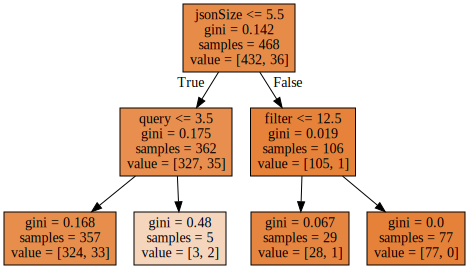

In [16]:
g  = extract_rules_FAILSUCCESS(test_df, generateSimulationIDCompact(tup))
g

In [17]:
def extract_rules_Runtime(df, filename, maxdepth=2):
    print("[<1s, <10s, <100s, >=100s]")
    
    #FIT Decision Tree
    model = tree.DecisionTreeClassifier(max_depth=maxdepth)

    mask = df['class'] >= 2.5
    df = df[mask]
    
    print(df['class'].value_counts())
    
    X = df[df.columns[1:]].as_matrix()


    y = df['class'].as_matrix()
    model.fit(X,y)

    treedata = tree.export_graphviz(model, out_file=None, feature_names=df.columns[1:], filled=True, proportion=False) 
    graph = graphviz.Source(treedata) 
    graph.format = 'svg'
    graph.render('img/TreesAllSims/'+filename+"_RUNTIME", view=False)
    
    graph.format = 'pdf'
    graph.render('img/TreesAllSims/'+filename+"_RUNTIME", view=False)
    
    graph.format = 'png'
    graph.render('img/TreesAllSims/'+filename+"_RUNTIME", view=False)
    
    return graph

[<1s, <10s, <100s, >=100s]
3    18
5     8
6     7
4     3
Name: class, dtype: int64


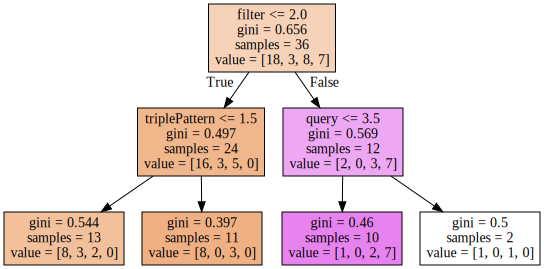

In [18]:
g  = extract_rules_Runtime(test_df, generateSimulationIDCompact(tup))
g

In [19]:
def extract_rules_errortype(df, filename, maxdepth=2):
    print("[incorrect, http error, timeout]")
    
    #FIT Decision Tree
    model = tree.DecisionTreeClassifier(max_depth=maxdepth)

    mask = df['class'] < 2.5
    df = df[mask]
    
    print(df['class'].value_counts())
    
    X = df[df.columns[1:]].as_matrix()


    y = df['class'].as_matrix()
    model.fit(X,y)

    treedata = tree.export_graphviz(model, out_file=None, feature_names=df.columns[1:], filled=True, proportion=False) 
    graph = graphviz.Source(treedata)
    
    graph.format = 'svg'
    graph.render('img/TreesAllSims/'+filename+"_ERRORTYPE", view=False)
    graph.format = 'pdf'
    graph.render('img/TreesAllSims/'+filename+"_ERRORTYPE", view=False)
    graph.format = 'png'
    graph.render('img/TreesAllSims/'+filename+"_ERRORTYPE", view=False)
    
    return graph

[incorrect, http error, timeout]
2    431
0      1
Name: class, dtype: int64


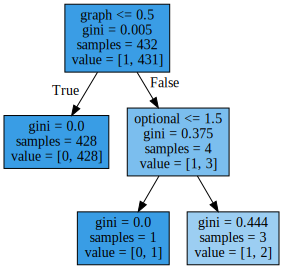

In [20]:
g  = extract_rules_errortype(test_df, generateSimulationIDCompact(tup))
g

# 2. Entreprise approaches for Ontoforce BM

In [21]:
tuple_list = [('Blazegraph', 1, 64, 'Ontoforce', 'Optimized', ''), \
              ('ES', 1, 64, 'Ontoforce', 'Default', ''), \
              ('GraphDB', 1, 64, 'Ontoforce', 'Optimized', ''), \
              ('Virtuoso', 1, 64, 'Ontoforce', 'Optimized', ''), \
              ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', 'VWall'), \
              ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '0'), \
              ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '2') \
             ]


all_rules = []

In [22]:
for tup in tuple_list:
    df = generate_query_classification_DF(tup)
    fname = generateSimulationIDCompact(tup)
    extract_rules_FAILSUCCESS(df, fname)
    extract_rules_errortype(df, fname)
    extract_rules_Runtime(df, fname)


Bla_N1_64_Ont_Opt
Number of queries: 468
[FAIL, SUCCESS]
0    432
1     36
Name: class, dtype: int64
[incorrect, http error, timeout]
2    431
0      1
Name: class, dtype: int64
[<1s, <10s, <100s, >=100s]
3    18
5     8
6     7
4     3
Name: class, dtype: int64
ES_N1_64_Ont_Def
Number of queries: 7338
[FAIL, SUCCESS]
1    4250
0    3088
Name: class, dtype: int64
[incorrect, http error, timeout]
1    1830
2    1257
0       1
Name: class, dtype: int64
[<1s, <10s, <100s, >=100s]
3    2117
4     992
5     767
6     374
Name: class, dtype: int64
Gra_N1_64_Ont_Opt
Number of queries: 3955
[FAIL, SUCCESS]
0    2372
1    1583
Name: class, dtype: int64
[incorrect, http error, timeout]
2    2372
Name: class, dtype: int64
[<1s, <10s, <100s, >=100s]
5    657
3    599
6    267
4     60
Name: class, dtype: int64
Vir_N1_64_Ont_Opt
Number of queries: 7338
[FAIL, SUCCESS]
1    7189
0     149
Name: class, dtype: int64
[incorrect, http error, timeout]
0    60
1    48
2    41
Name: class, dtype: int64
[<1

In [23]:
rules_fs = []
rules_etype = []
rules_time = []

#blazegraph
rules_etype.append("GRA = 0")
rules_etype.append("GRA > 0, FIL = 0")
rules_etype.append("GRA > 0, FIL > 0")

rules_fs.append("TP <  10, Q < 4")
rules_fs.append("TP <  10, Q >= 4")
rules_fs.append("TP >= 10, FIL < 13")
rules_fs.append("TP >= 10, FIL >= 13")

rules_time.append("TP <  4, TP <  2")
rules_time.append("TP <  4, TP >= 2")
rules_time.append("TP >= 4, Q  <  4 ")
rules_time.append("TP >= 4, Q  >= 4")

#ES
rules_etype.append("Q <  3, Q <  2")
rules_etype.append("Q <  3, Q >= 2")
rules_etype.append("Q >= 4, OPT <  2")
rules_etype.append("Q >= 4, OPT >= 2")


rules_fs.append("Q <  2, TP <  1")
rules_fs.append("Q <  2, TP >= 1")
rules_fs.append("Q >= 2, OPT <  2")
rules_fs.append("Q >= 2, OPT >= 2")

rules_time.append("FIL <  2, TP <  4")
rules_time.append("FIL <  2, TP >= 4")
rules_time.append("FIL >= 2, TP <  7")
rules_time.append("FIL >= 2, TP >= 7")

#GraphDB
rules_fs.append("FIL <  2, OPT <  1")
rules_fs.append("FIL <  2, OPT >= 1")
rules_fs.append("FIL >= 2, Q < 4")
rules_fs.append("FIL >= 2, Q >= 4")

rules_time.append("FIL <  1, TP <  2")
rules_time.append("FIL <  1, TP >= 2")
rules_time.append("FIL >= 1, TP <  7")
rules_time.append("FIL >= 1, TP >= 7")

#V32
rules_etype.append("TP <  22, FIL IN <  2")
rules_etype.append("TP <  22, FIL IN >= 2")
rules_etype.append("TP >= 22, ORD <     1")
rules_etype.append("TP >= 22, ORD >=    1")

rules_fs.append("TP <  37, OPT < 6")
rules_fs.append("TP <  37, OPT >= 6")
rules_fs.append("TP >= 37")

rules_time.append("TP <  24, FIL <  1")
rules_time.append("TP <  24, FIL >= 1")
rules_time.append("TP >= 24, FIL IN <  14")
rules_time.append("TP >= 24, FIL IN >= 14")

#V64
rules_etype.append("TP <  22, FIL IN <  2")
rules_etype.append("TP <  22, FIL IN >= 2")
rules_etype.append("TP >= 22, ORD <     1" )
rules_etype.append("TP >= 22, ORD >=    1")


#rules_fs.append("TP <  37, OPT < 6")
#rules_fs.append("TP <  37, OPT >= 6")
#rules_fs.append("TP >= 37")

rules_time.append("TP <  15, FIL <  1")
rules_time.append("TP <  15, FIL >= 1")
rules_time.append("TP >= 15, FIL IN  < 4")
rules_time.append("TP >= 15, FIL IN >= 4")

#VN3_0
rules_etype.append("GRA <  1, GRP <  4")
rules_etype.append("GRA <  1, GRP >= 4")
rules_etype.append("GRA >= 1, FIL <  1")
rules_etype.append("GRA >= 1, FIL >= 1")

rules_fs.append("Q <  4, GRA <  1")
rules_fs.append("Q <  4, GRA >= 1")
rules_fs.append("Q >= 4, FIL IN <  14")
rules_fs.append("Q >= 4, FIL IN >= 14")

rules_time.append("TP <  16, FIL <  1" )
rules_time.append("TP <  16, FIL >= 1")
rules_time.append("TP >= 16  FIL IN  <  4")
rules_time.append("TP >= 16  FIL IN  >= 4")

#VN3_2
rules_etype.append("FIL IN  <  2, Q <  3")
rules_etype.append("FIL IN  <  2, Q >= 3")
rules_etype.append("FIL IN  >= 2, CNT < 1")
rules_etype.append("FIL IN  >= 2, CNT >= 1")


rules_fs.append("TP <  2, ORD <  1" )
rules_fs.append("TP <  2, ORD >= 1")
rules_fs.append("TP >= 2, ORD <  1")
rules_fs.append("TP >= 2, ORD >= 1")

rules_fs

['TP <  10, Q < 4',
 'TP <  10, Q >= 4',
 'TP >= 10, FIL < 13',
 'TP >= 10, FIL >= 13',
 'Q <  2, TP <  1',
 'Q <  2, TP >= 1',
 'Q >= 2, OPT <  2',
 'Q >= 2, OPT >= 2',
 'FIL <  2, OPT <  1',
 'FIL <  2, OPT >= 1',
 'FIL >= 2, Q < 4',
 'FIL >= 2, Q >= 4',
 'TP <  37, OPT < 6',
 'TP <  37, OPT >= 6',
 'TP >= 37',
 'Q <  4, GRA <  1',
 'Q <  4, GRA >= 1',
 'Q >= 4, FIL IN <  14',
 'Q >= 4, FIL IN >= 14',
 'TP <  2, ORD <  1',
 'TP <  2, ORD >= 1',
 'TP >= 2, ORD <  1',
 'TP >= 2, ORD >= 1']

In [24]:
rules_etype

['GRA = 0',
 'GRA > 0, FIL = 0',
 'GRA > 0, FIL > 0',
 'Q <  3, Q <  2',
 'Q <  3, Q >= 2',
 'Q >= 4, OPT <  2',
 'Q >= 4, OPT >= 2',
 'TP <  22, FIL IN <  2',
 'TP <  22, FIL IN >= 2',
 'TP >= 22, ORD <     1',
 'TP >= 22, ORD >=    1',
 'TP <  22, FIL IN <  2',
 'TP <  22, FIL IN >= 2',
 'TP >= 22, ORD <     1',
 'TP >= 22, ORD >=    1',
 'GRA <  1, GRP <  4',
 'GRA <  1, GRP >= 4',
 'GRA >= 1, FIL <  1',
 'GRA >= 1, FIL >= 1',
 'FIL IN  <  2, Q <  3',
 'FIL IN  <  2, Q >= 3',
 'FIL IN  >= 2, CNT < 1',
 'FIL IN  >= 2, CNT >= 1']

In [25]:
rules_time

['TP <  4, TP <  2',
 'TP <  4, TP >= 2',
 'TP >= 4, Q  <  4 ',
 'TP >= 4, Q  >= 4',
 'FIL <  2, TP <  4',
 'FIL <  2, TP >= 4',
 'FIL >= 2, TP <  7',
 'FIL >= 2, TP >= 7',
 'FIL <  1, TP <  2',
 'FIL <  1, TP >= 2',
 'FIL >= 1, TP <  7',
 'FIL >= 1, TP >= 7',
 'TP <  24, FIL <  1',
 'TP <  24, FIL >= 1',
 'TP >= 24, FIL IN <  14',
 'TP >= 24, FIL IN >= 14',
 'TP <  15, FIL <  1',
 'TP <  15, FIL >= 1',
 'TP >= 15, FIL IN  < 4',
 'TP >= 15, FIL IN >= 4',
 'TP <  16, FIL <  1',
 'TP <  16, FIL >= 1',
 'TP >= 16  FIL IN  <  4',
 'TP >= 16  FIL IN  >= 4']

# 3. Creating a DF with distribution in terms of rules

In [26]:
rules_fs


['TP <  10, Q < 4',
 'TP <  10, Q >= 4',
 'TP >= 10, FIL < 13',
 'TP >= 10, FIL >= 13',
 'Q <  2, TP <  1',
 'Q <  2, TP >= 1',
 'Q >= 2, OPT <  2',
 'Q >= 2, OPT >= 2',
 'FIL <  2, OPT <  1',
 'FIL <  2, OPT >= 1',
 'FIL >= 2, Q < 4',
 'FIL >= 2, Q >= 4',
 'TP <  37, OPT < 6',
 'TP <  37, OPT >= 6',
 'TP >= 37',
 'Q <  4, GRA <  1',
 'Q <  4, GRA >= 1',
 'Q >= 4, FIL IN <  14',
 'Q >= 4, FIL IN >= 14',
 'TP <  2, ORD <  1',
 'TP <  2, ORD >= 1',
 'TP >= 2, ORD <  1',
 'TP >= 2, ORD >= 1']

In [27]:
print("TP: 2,10,37")
print("Q: 2, 4")
print("FIL: 2,13")
print("FIL IN: 14")
print("TP: 1,10,37")
print("GRA: 1")
print("OPT: 1,2,6")
print("ORD: 1")

TP: 2,10,37
Q: 2, 4
FIL: 2,13
FIL IN: 14
TP: 1,10,37
GRA: 1
OPT: 1,2,6
ORD: 1


In [28]:
df = generate_query_classification_DF(tup)

TP = df['triplePattern']
Q = df['query']
FIL = df['filter']
rules = [(TP < 10) & (Q < 4), (TP < 10) & (Q >=4), (TP >= 10) & (FIL < 13), (TP >= 10) & (FIL >=13)]

df[rules[1]]['class'].value_counts()


Vir_N3_64_Ont_Opt_2
Number of queries: 7338


1    48
Name: class, dtype: int64

In [29]:
test_df = pd.DataFrame(df[rules[1]]['class'].value_counts(), index=np.arange(0,7)).fillna(0)
test_df['class'] = pd.to_numeric(test_df['class'], downcast='integer')
test_df.index = all_classnames
test_df = test_df.rename(columns={'class': generateSimulationIDCompact(tup)})
test_df = test_df.T
test_df['sample'] = test_df.sum(axis=1)
test_df['rule'] = rules_fs[1]

test_df.reset_index().rename(columns={'index': 'sim'})

,sim,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
0,Vir_N3_64_Ont_Opt_2,0,48,0,0,0,0,0,48,"TP < 10, Q >= 4"


In [30]:
def map_rule_to_DF(tup, df):
    if tup[1] == '<':
        #op <
        return df[tup[0]] < tup[2]
    else:
        #op >=
        return df[tup[0]] >= tup[2]

def generateRow(tup, rules, rule_str):
    df = generate_query_classification_DF(tup)
    
    masks = [map_rule_to_DF(r,df) for r in rules]
    
    if len(masks) == 0:
        df_filtered = df
    
    else:
        union_mask = masks[0]
        for i in range(1,len(masks)):
            union_mask = union_mask & masks[i]
    
        df_filtered = df[union_mask]
        
        test_df = pd.DataFrame(df_filtered['class'].value_counts(), index=np.arange(0,7)).fillna(0)
        test_df['class'] = pd.to_numeric(test_df['class'], downcast='integer')
        test_df.index = all_classnames
        test_df = test_df.rename(columns={'class': generateSimulationIDCompact(tup)})
        test_df = test_df.T
        test_df['sample'] = test_df.sum(axis=1)
        test_df['rule'] = rule_str

        df_result = test_df.reset_index().rename(columns={'index': 'sim'})
        return df_result

In [31]:
generateRow(tup, [('triplePattern','<',10),('query','<',4)], "TP < 10, Q < 4")

Vir_N3_64_Ont_Opt_2
Number of queries: 7338


,sim,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
0,Vir_N3_64_Ont_Opt_2,2682,168,0,2502,0,0,0,5352,"TP < 10, Q < 4"


In [32]:
rules = [
    [('triplePattern','<',10),  ('query','<',4)  ], \
    [('triplePattern','<',10),  ('query','>=',4) ], \
    [('triplePattern','>=',10), ('query','<',13) ], \
    [('triplePattern','>=',10), ('query','>=',13)], \

    [('query','<',2), ('triplePattern','<',1) ], \
    [('query','<',2), ('triplePattern','>=',1)], \
    [('query','>=',2), ('optional','<',2)     ], \
    [('query','>=',2), ('optional','>=',2)    ], \

    [('filter','<',2), ('optional','<',1) ], \
    [('filter','<',2), ('optional','>=',1)], \
    [('filter','>=',2), ('query','<',4)   ], \
    [('filter','>=',2), ('query','>=',4)  ], \

    [('triplePattern','<',37), ('optional','<',6) ], \
    [('triplePattern','<',37), ('optional','>=',6)], \
    [('triplePattern','>=',37)], \
    
    [('query','<',4), ('graph','<',1) ], \
    [('query','<',4), ('graph','>=',1)], \
    [('query','>=',4), ('filter_in','<',14)   ], \
    [('query','>=',4), ('filter_in','>=',14)  ], \

    [('triplePattern','<',2), ('order','<',1) ], \
    [('triplePattern','<',2), ('order','>=',1)], \
    [('triplePattern','>=',2), ('order','<',1)   ], \
    [('triplePattern','>=',2), ('order','>=',1)  ], \
]
rules_fs

['TP <  10, Q < 4',
 'TP <  10, Q >= 4',
 'TP >= 10, FIL < 13',
 'TP >= 10, FIL >= 13',
 'Q <  2, TP <  1',
 'Q <  2, TP >= 1',
 'Q >= 2, OPT <  2',
 'Q >= 2, OPT >= 2',
 'FIL <  2, OPT <  1',
 'FIL <  2, OPT >= 1',
 'FIL >= 2, Q < 4',
 'FIL >= 2, Q >= 4',
 'TP <  37, OPT < 6',
 'TP <  37, OPT >= 6',
 'TP >= 37',
 'Q <  4, GRA <  1',
 'Q <  4, GRA >= 1',
 'Q >= 4, FIL IN <  14',
 'Q >= 4, FIL IN >= 14',
 'TP <  2, ORD <  1',
 'TP <  2, ORD >= 1',
 'TP >= 2, ORD <  1',
 'TP >= 2, ORD >= 1']

In [33]:
rows = []
for tup in tuple_list:
    for i, rule in enumerate(rules):
        rows.append(generateRow(tup, rule, rules_fs[i]))
        

Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
Bla_N1_64_Ont_Opt
Number of queries: 468
ES_N1_64_Ont_Def
Number of queries: 7338
ES_N1_64_Ont_Def

In [34]:
df_all = pd.concat(rows)

In [35]:
#for i in range(1,8):
#    df_all[df_all.columns[i]] = df_all[df_all.columns[i]] / df_all['sample']

df_all.head(n=5)

,sim,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
0,Bla_N1_64_Ont_Opt,1,0,291,16,3,7,5,323,"TP < 10, Q < 4"
0,Bla_N1_64_Ont_Opt,0,0,3,1,0,1,0,5,"TP < 10, Q >= 4"
0,Bla_N1_64_Ont_Opt,0,0,137,1,0,0,2,140,"TP >= 10, FIL < 13"
0,Bla_N1_64_Ont_Opt,0,0,0,0,0,0,0,0,"TP >= 10, FIL >= 13"
0,Bla_N1_64_Ont_Opt,0,0,0,0,0,0,0,0,"Q < 2, TP < 1"


In [36]:
df_all.sort_values('#incorrect', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,283,9,0,5,6,304,"TP >= 2, ORD < 1"
ES_N1_64_Ont_Def,1,1393,1167,2095,983,763,372,6774,"Q < 4, GRA < 1"
Gra_N1_64_Ont_Opt,0,0,0,0,0,0,0,0,"TP >= 10, FIL >= 13"
Vir_N1_32_Ont_Opt_VWall,60,0,39,5911,499,459,286,7254,"TP < 37, OPT < 6"
Vir_N1_64_Ont_Opt,60,0,41,5957,734,217,245,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,2718,588,0,3948,0,0,0,7254,"TP < 37, OPT < 6"


In [37]:
df_all.sort_values('#http error', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,264,16,3,7,3,294,"Q < 2, TP >= 1"
ES_N1_64_Ont_Def,1,1790,1244,2100,983,764,372,7254,"TP < 37, OPT < 6"
Gra_N1_64_Ont_Opt,0,0,1642,477,42,528,188,2877,"TP < 10, Q < 4"
Vir_N1_32_Ont_Opt_VWall,12,48,19,119,268,7,43,516,"FIL >= 2, Q >= 4"
Vir_N1_64_Ont_Opt,6,48,18,258,149,27,52,558,"TP >= 2, ORD >= 1"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,2718,588,0,3948,0,0,0,7254,"TP < 37, OPT < 6"


In [38]:
df_all.sort_values('#timeout', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,425,18,3,8,7,462,"TP < 37, OPT < 6"
ES_N1_64_Ont_Def,1,1790,1244,2100,983,764,372,7254,"TP < 37, OPT < 6"
Gra_N1_64_Ont_Opt,0,0,2340,593,59,649,267,3908,"TP < 37, OPT < 6"
Vir_N1_32_Ont_Opt_VWall,60,0,39,5911,499,459,286,7254,"TP < 37, OPT < 6"
Vir_N1_64_Ont_Opt,60,0,41,5957,734,217,245,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,228,0,0,18,0,0,0,246,"TP < 2, ORD >= 1"


In [39]:
df_all.sort_values('#<1s', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,425,18,3,8,7,462,"TP < 37, OPT < 6"
ES_N1_64_Ont_Def,1,1790,1244,2100,983,764,372,7254,"TP < 37, OPT < 6"
Gra_N1_64_Ont_Opt,0,0,2340,593,59,649,267,3908,"TP < 37, OPT < 6"
Vir_N1_32_Ont_Opt_VWall,60,0,39,5911,499,459,286,7254,"TP < 37, OPT < 6"
Vir_N1_64_Ont_Opt,60,0,41,5957,734,217,245,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,2718,588,0,3948,0,0,0,7254,"TP < 37, OPT < 6"


In [40]:
df_all.sort_values('#<10s', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,291,16,3,7,5,323,"TP < 10, Q < 4"
ES_N1_64_Ont_Def,1,1790,1244,2100,983,764,372,7254,"TP < 37, OPT < 6"
Gra_N1_64_Ont_Opt,0,0,2095,591,60,647,263,3656,"Q < 4, GRA < 1"
Vir_N1_32_Ont_Opt_VWall,60,0,39,5911,499,459,286,7254,"TP < 37, OPT < 6"
Vir_N1_64_Ont_Opt,60,0,41,5957,734,217,245,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,2682,168,0,2502,0,0,0,5352,"TP < 10, Q < 4"


In [41]:
df_all.sort_values('#<100s', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,425,18,3,8,7,462,"TP < 37, OPT < 6"
ES_N1_64_Ont_Def,1,1790,1244,2100,983,764,372,7254,"TP < 37, OPT < 6"
Gra_N1_64_Ont_Opt,0,0,2340,593,59,649,267,3908,"TP < 37, OPT < 6"
Vir_N1_32_Ont_Opt_VWall,60,0,39,5911,499,459,286,7254,"TP < 37, OPT < 6"
Vir_N1_64_Ont_Opt,60,0,41,5957,734,217,245,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,0,252,0,0,0,0,0,252,"Q >= 4, FIL IN >= 14"


In [42]:
df_all.sort_values('#>100s', ascending=False).groupby('sim').first()

,#incorrect,#http error,#timeout,#<1s,#<10s,#<100s,#>100s,sample,rule
sim,,,,,,,,,
Bla_N1_64_Ont_Opt,1,0,425,18,3,8,7,462,"TP < 37, OPT < 6"
ES_N1_64_Ont_Def,1,1393,1167,2095,983,763,372,6774,"Q < 4, GRA < 1"
Gra_N1_64_Ont_Opt,0,0,2340,593,59,649,267,3908,"TP < 37, OPT < 6"
Vir_N1_32_Ont_Opt_VWall,60,0,39,5911,499,459,286,7254,"TP < 37, OPT < 6"
Vir_N1_64_Ont_Opt,60,0,41,5957,734,217,245,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_0,27,3118,19,3513,377,149,51,7254,"TP < 37, OPT < 6"
Vir_N3_64_Ont_Opt_2,0,252,0,0,0,0,0,252,"Q >= 4, FIL IN >= 14"


In [43]:
df_all.sort_values(['rule', 'sim']).to_csv('TestRules.csv', header=True, sep='\t')




In [44]:
dfs = []
for i, tup in enumerate(tuple_list):
    df = generate_query_classification_DF(tup)
    df['sim'] = i
    dfs.append(df)
    

Bla_N1_64_Ont_Opt
Number of queries: 468
ES_N1_64_Ont_Def
Number of queries: 7338
Gra_N1_64_Ont_Opt
Number of queries: 3955
Vir_N1_64_Ont_Opt
Number of queries: 7338
Vir_N1_32_Ont_Opt_VWall
Number of queries: 7338
Vir_N3_64_Ont_Opt_0
Number of queries: 7338
Vir_N3_64_Ont_Opt_2
Number of queries: 7338


In [45]:
all_queries = pd.concat(dfs)

In [46]:
mask = all_queries['sim'] < 4
all_queries = all_queries[mask]

[FAIL, SUCCESS]
1    13058
0     6041
Name: class, dtype: int64


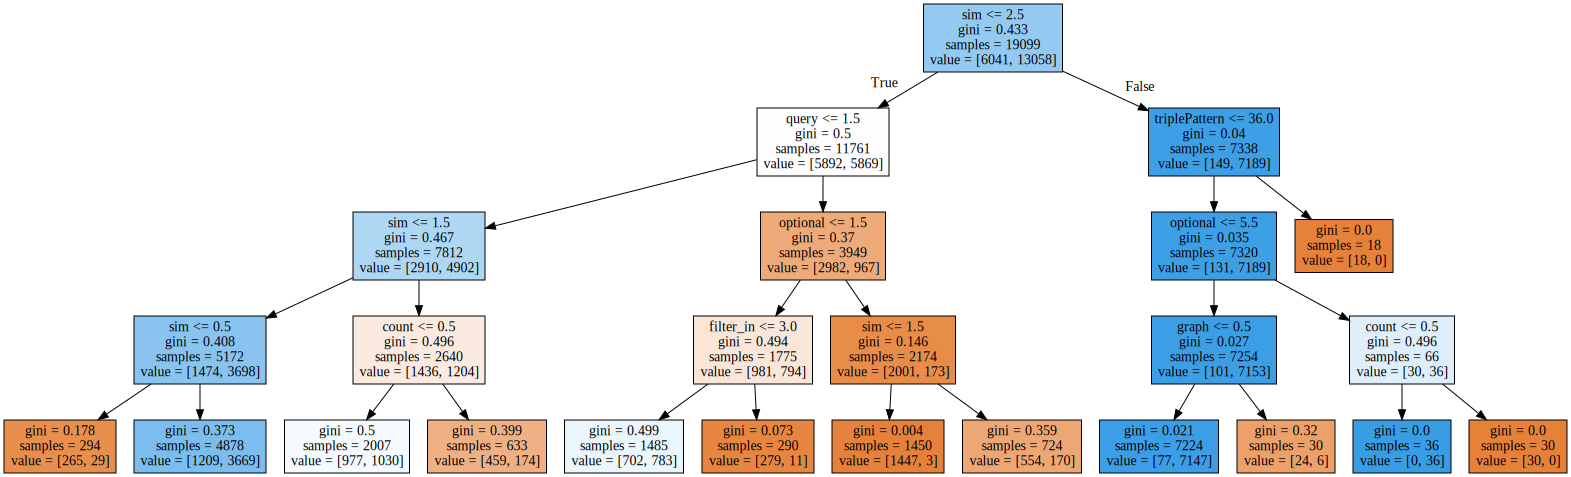

In [47]:
extract_rules_FAILSUCCESS(all_queries, 'allqueries_d4', maxdepth=4)


[FAIL, SUCCESS]
1    13058
0     6041
Name: class, dtype: int64


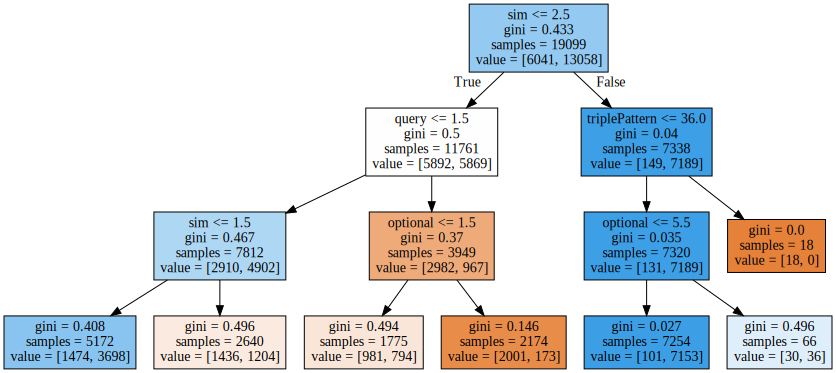

In [48]:
extract_rules_FAILSUCCESS(all_queries, 'allqueries_d3', maxdepth=3)


[FAIL, SUCCESS]
1    13058
0     6041
Name: class, dtype: int64


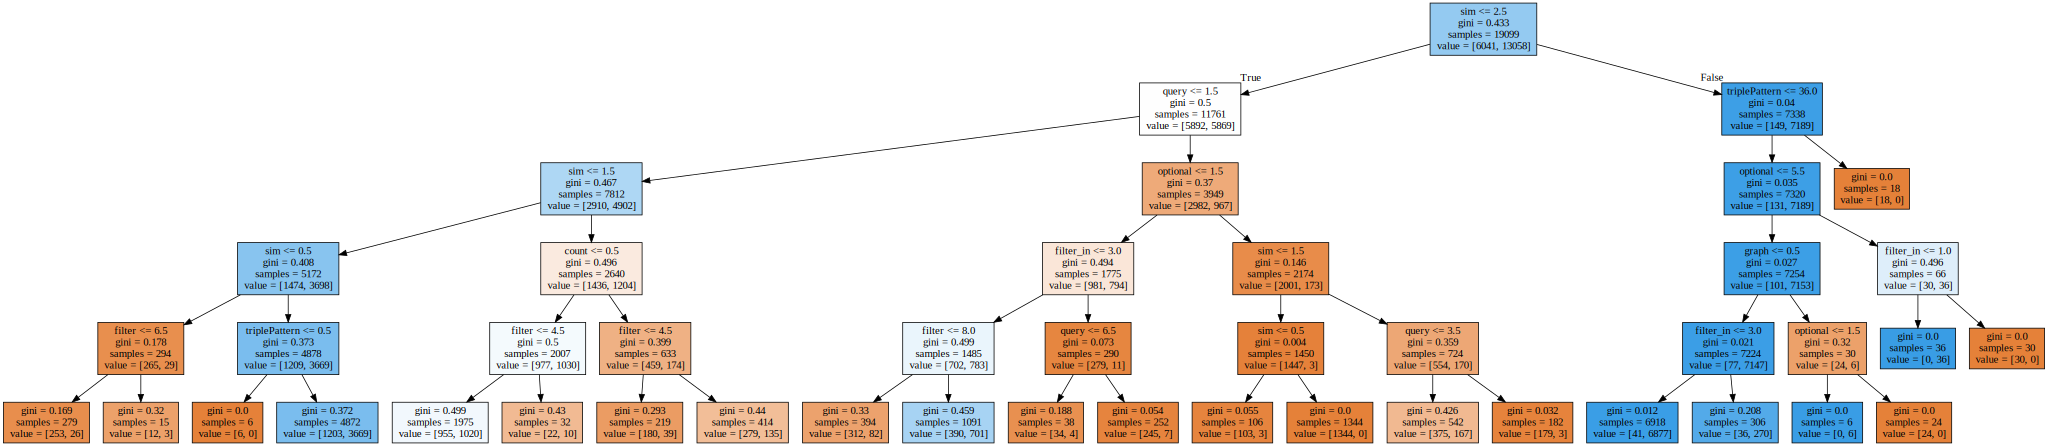

In [49]:
extract_rules_FAILSUCCESS(all_queries, 'allqueries_d5', maxdepth=5)


[FAIL, SUCCESS]
1    13058
0     6041
Name: class, dtype: int64


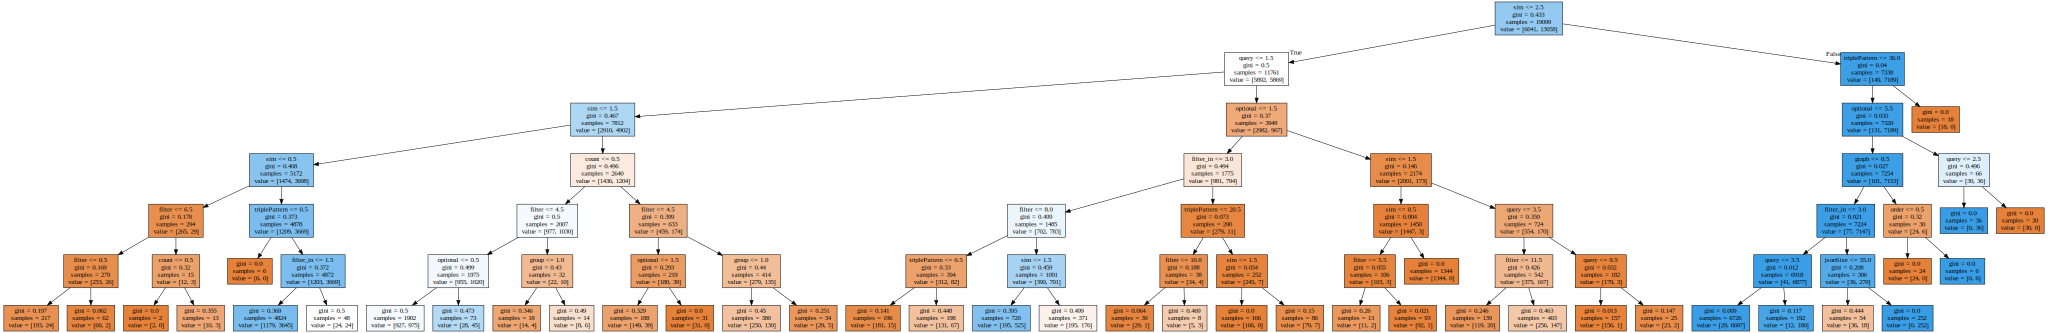

In [50]:
extract_rules_FAILSUCCESS(all_queries, 'allqueries_d6', maxdepth=6)


[<1s, <10s, <100s, >=100s]
3    8726
4    1790
5    1649
6     893
Name: class, dtype: int64


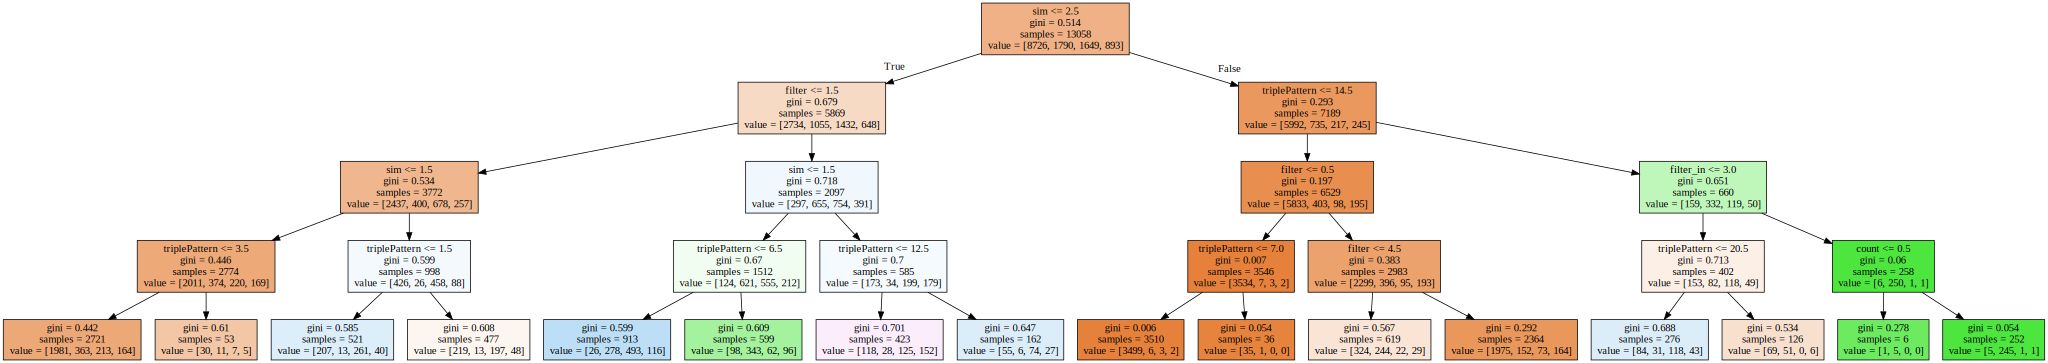

In [51]:
extract_rules_Runtime(all_queries, 'allqueries_d4', maxdepth=4)


[incorrect, http error, timeout]
2    4101
1    1878
0      62
Name: class, dtype: int64


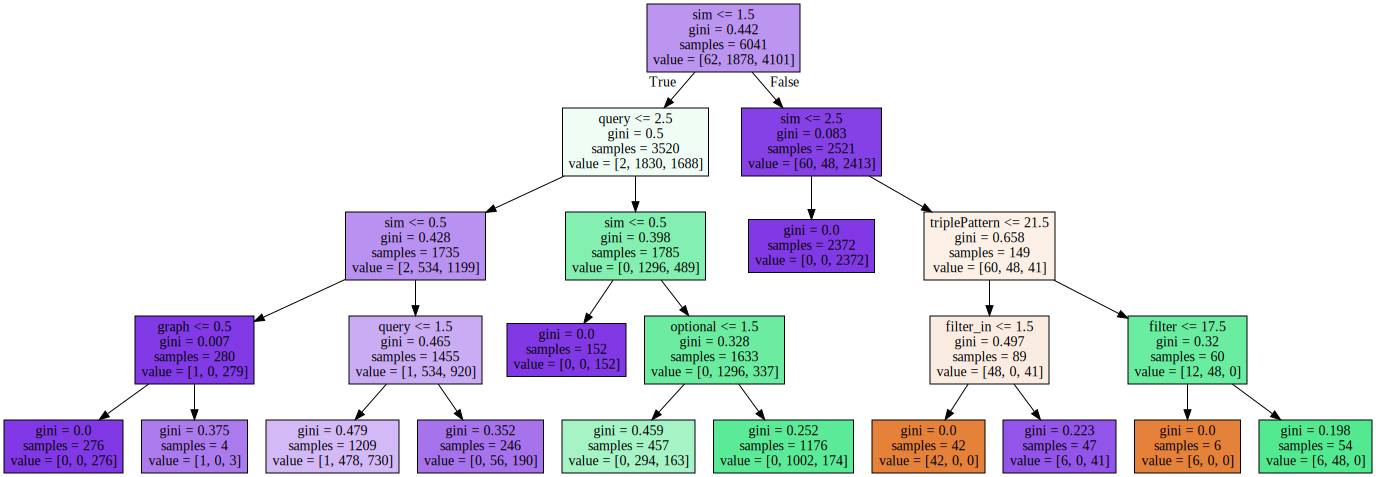

In [52]:
extract_rules_errortype(all_queries, 'allqueries_d4', maxdepth=4)


# Overall Regressor for all runtimes?

In [53]:
dfs = []
for i, tup in enumerate(tuple_list):
    df = generate_query_classification_and_runtime_DF(tup)
    df['sim'] = i
    dfs.append(df)
    
    
df_all_rt = pd.concat(dfs)    

Bla_N1_64_Ont_Opt
Number of queries: 468
ES_N1_64_Ont_Def
Number of queries: 7338
Gra_N1_64_Ont_Opt
Number of queries: 3955
Vir_N1_64_Ont_Opt
Number of queries: 7338
Vir_N1_32_Ont_Opt_VWall
Number of queries: 7338
Vir_N3_64_Ont_Opt_0
Number of queries: 7338
Vir_N3_64_Ont_Opt_2
Number of queries: 7338


In [54]:
df_all_rt

mask = df_all_rt['sim'] < 4
all_queries_with_runtime = df_all_rt[mask]
all_queries_with_runtime.head(n=5)

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
xzaub,0,0.164710,0.0,3.0,0.0,0.0,1.0,0.0,1.0,9.0,1.0,1,0
xdm,3,0.055763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0
xzalo,5,52.323868,2.0,1.0,0.0,1.0,7.0,1.0,0.0,5.0,1.0,1,0
xjf,2,1200.000000,4.0,3.0,0.0,2.0,20.0,0.0,0.0,17.0,3.0,10,0
xyc,2,1200.000000,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,0


In [55]:


def extract_rules_RuntimeRegression(df, filename, maxdepth=2):
    print("[<1s, <10s, <100s, >=100s]")
    
    #FIT Decision Tree
    model = tree.DecisionTreeRegressor(max_depth=maxdepth)

    mask = df['class'] >= 2.5
    df = df[mask]
    
    print(df['class'].value_counts())
    
    X = df[df.columns[2:]].as_matrix()


    y = df['runtime'].as_matrix()
    model.fit(X,y)

    treedata = tree.export_graphviz(model, out_file=None, feature_names=df.columns[2:], filled=True, proportion=False) 
    graph = graphviz.Source(treedata) 
    graph.format = 'svg'
    graph.render('img/decisiontrees/'+filename+"_RUNTIME_REGRESSION", view=False)
    
    graph.format = 'pdf'
    graph.render('img/decisiontrees/'+filename+"_RUNTIME_REGRESSION", view=False)
    
    graph.format = 'png'
    graph.render('img/decisiontrees/'+filename+"_RUNTIME_REGRESSION", view=False)
    
    return graph

[<1s, <10s, <100s, >=100s]
3    8726
4    1790
5    1649
6     893
Name: class, dtype: int64


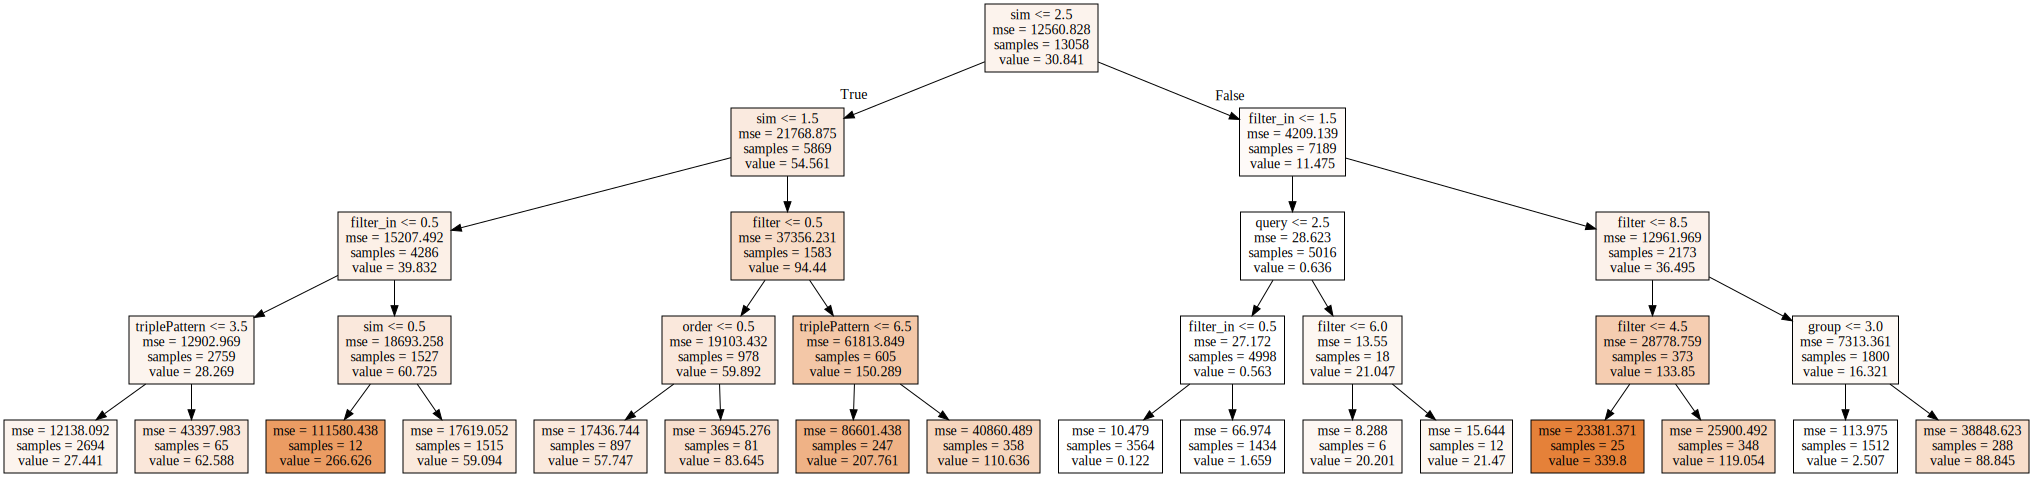

In [56]:
extract_rules_RuntimeRegression(all_queries_with_runtime, 'allqueries_d4', maxdepth=4)


[<1s, <10s, <100s, >=100s]
3    8726
4    1790
5    1649
6     893
Name: class, dtype: int64


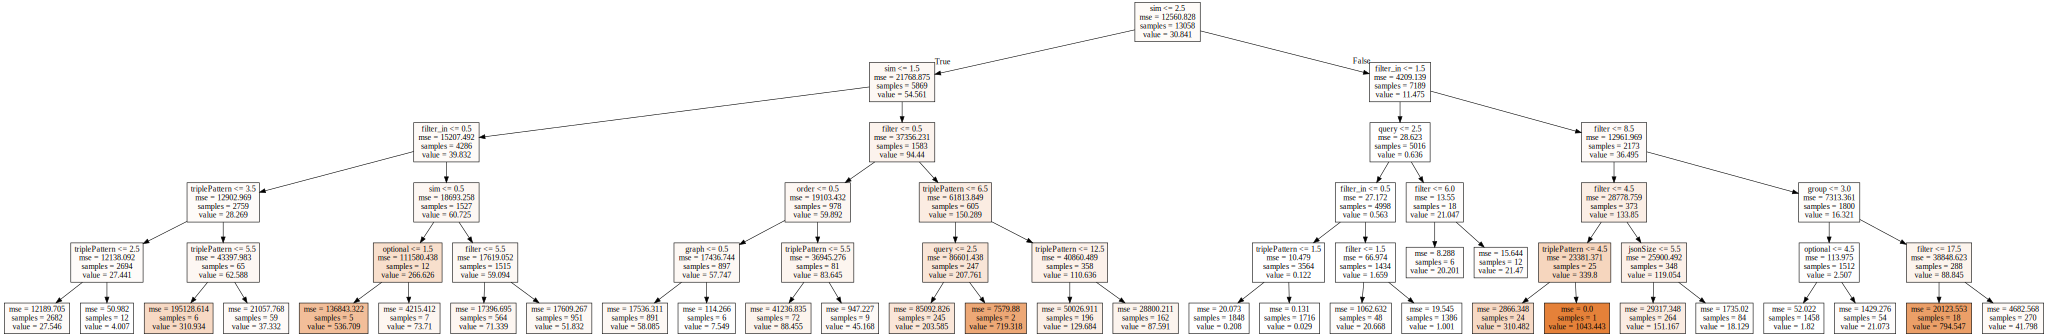

In [57]:
extract_rules_RuntimeRegression(all_queries_with_runtime, 'allqueries_d5', maxdepth=5)


## Postprocess some of the counterintuitive results

In [58]:
FILIN = all_queries_with_runtime['filter_in']
FIL = all_queries_with_runtime['filter']
virtuoso = all_queries_with_runtime['sim'] == 3
SUCCESS = all_queries_with_runtime['class'] >= 3

In [59]:
mask1 = (FILIN >= 2) & (FIL < 5)
node_left = all_queries_with_runtime[mask1 & virtuoso & SUCCESS].describe().loc['mean']

In [60]:
all_queries_with_runtime[mask1 & virtuoso & SUCCESS].describe()

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
count,25.0,25.000000,25.0,25.000000,25.000000,25.0,25.000000,25.0,25.0,25.000000,25.000000,25.0,25.0
mean,6.0,339.800448,0.0,1.000000,0.480000,2.0,3.480000,1.0,0.0,3.080000,1.560000,10.0,3.0
std,0.0,156.062792,0.0,0.707107,0.509902,0.0,0.509902,0.0,0.0,0.812404,0.583095,0.0,0.0
min,6.0,221.445126,0.0,0.000000,0.000000,2.0,3.000000,1.0,0.0,2.000000,1.000000,10.0,3.0
25%,6.0,263.091368,0.0,1.000000,0.000000,2.0,3.000000,1.0,0.0,3.000000,1.000000,10.0,3.0
50%,6.0,316.342393,0.0,1.000000,0.000000,2.0,3.000000,1.0,0.0,3.000000,2.000000,10.0,3.0
75%,6.0,359.924931,0.0,1.000000,1.000000,2.0,4.000000,1.0,0.0,4.000000,2.000000,10.0,3.0
max,6.0,1043.442580,0.0,2.000000,1.000000,2.0,4.000000,1.0,0.0,5.000000,3.000000,10.0,3.0


In [61]:
mask1 = (FILIN >= 2) & (FIL >= 5)
node_right = all_queries_with_runtime[mask1 & virtuoso & SUCCESS].describe().loc['mean']

In [62]:
all_queries_with_runtime[mask1 & virtuoso & SUCCESS].describe()

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.00000,2148.0,2148.000000,2148.000000,2148.000000,2148.0
mean,3.679236,32.965115,0.631285,2.167598,0.120112,3.427374,13.494413,0.98324,0.0,15.201117,3.759777,17.416201,3.0
std,0.986635,108.457458,1.391969,1.246451,0.325168,3.857117,6.184289,0.12840,0.0,7.587316,2.018088,30.397230,0.0
min,3.000000,0.004155,0.000000,0.000000,0.000000,2.000000,5.000000,0.00000,0.0,4.000000,1.000000,1.000000,3.0
25%,3.000000,0.048247,0.000000,1.000000,0.000000,2.000000,9.000000,1.00000,0.0,11.000000,3.000000,1.000000,3.0
50%,3.000000,0.321596,0.000000,2.000000,0.000000,2.000000,12.000000,1.00000,0.0,11.500000,3.000000,10.000000,3.0
75%,4.000000,3.335027,0.000000,3.000000,0.000000,2.000000,19.000000,1.00000,0.0,17.000000,3.000000,10.000000,3.0
max,6.000000,1039.810281,4.000000,5.000000,1.000000,16.000000,27.000000,1.00000,0.0,34.000000,10.000000,100.000000,3.0


In [63]:
node_left - node_right

class              2.320764
runtime          306.835333
group             -0.631285
optional          -1.167598
order              0.359888
filter_in         -1.427374
filter           -10.014413
count              0.016760
graph              0.000000
triplePattern    -12.121117
query             -2.199777
jsonSize          -7.416201
sim                0.000000
Name: mean, dtype: float64

### Op basis van query features kunnen we dit dus niet verklaren!?

node right heeft voor alles een hogere mean!!


In [64]:
mask1 = (FILIN >= 2) & (FIL < 5)
all_queries_with_runtime[mask1 & virtuoso & SUCCESS]

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
xlk,6,1043.442580,0.0,1.0,0.0,2.0,3.0,1.0,0.0,5.0,3.0,10,3
xzagn,6,251.761276,0.0,1.0,1.0,2.0,3.0,1.0,0.0,3.0,2.0,10,3
xzagn,6,359.924931,0.0,1.0,1.0,2.0,3.0,1.0,0.0,3.0,2.0,10,3
xzagn,6,223.800382,0.0,1.0,1.0,2.0,3.0,1.0,0.0,3.0,2.0,10,3
xzagn,6,316.342393,0.0,1.0,1.0,2.0,3.0,1.0,0.0,3.0,2.0,10,3
xzagn,6,359.461925,0.0,1.0,1.0,2.0,3.0,1.0,0.0,3.0,2.0,10,3
xzagn,6,325.303642,0.0,1.0,1.0,2.0,3.0,1.0,0.0,3.0,2.0,10,3
xzape,6,243.345303,0.0,2.0,1.0,2.0,4.0,1.0,0.0,4.0,2.0,10,3
xzape,6,320.267628,0.0,2.0,1.0,2.0,4.0,1.0,0.0,4.0,2.0,10,3
xzape,6,282.462956,0.0,2.0,1.0,2.0,4.0,1.0,0.0,4.0,2.0,10,3


* **xzagn** (filter in is quite big?) 18kb

```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT ?val (coalesce(?label, ?val) AS ?val_label) ?vc WHERE { 
    {
        SELECT ?val (COUNT(DISTINCT ?id) as ?vc) WHERE {
            ?id <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> ?val.
            FILTER (?val IN (...)) 
        } 
        GROUP BY ?val
     } 
     OPTIONAL { 
         ?val <http://ns.ontoforce.com/2013/disqover#preferredLabel> ?label
     } 
} 
ORDER BY DESC(?vc) ?val_label 
LIMIT 15 
OFFSET 0 
```

* **xzaso** (big filter in) 18kb

```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT (COUNT(DISTINCT ?id) as ?total_count) WHERE { 
    ?id <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> ?v.
    FILTER (... IN...) 
    FILTER (?facet_value_1 IN (...) 
    OPTIONAL{ 
        ?id <http://ns.ontoforce.com/2013/disqover#source_organism> ?facet_value_2. 
    } 
    FILTER(!BOUND(?facet_value_2)) } 

```


In [65]:
mask1 = (FILIN >= 2) & (FIL > 5)
all_queries_with_runtime[mask1 & virtuoso & SUCCESS]

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
xaa,3,0.066875,0.0,1.0,0.0,2.0,13.0,1.0,0.0,14.0,3.0,10,3
xaa,3,0.157113,0.0,1.0,0.0,2.0,13.0,1.0,0.0,14.0,3.0,10,3
xaa,3,0.083071,0.0,1.0,0.0,2.0,13.0,1.0,0.0,14.0,3.0,10,3
xaa,3,0.082195,0.0,1.0,0.0,2.0,13.0,1.0,0.0,14.0,3.0,10,3
xaa,3,0.078418,0.0,1.0,0.0,2.0,13.0,1.0,0.0,14.0,3.0,10,3
xaa,3,0.086169,0.0,1.0,0.0,2.0,13.0,1.0,0.0,14.0,3.0,10,3
xaf,3,0.086293,0.0,2.0,1.0,2.0,13.0,1.0,0.0,15.0,4.0,10,3
xaf,3,0.071201,0.0,2.0,1.0,2.0,13.0,1.0,0.0,15.0,4.0,10,3
xaf,3,0.107397,0.0,2.0,1.0,2.0,13.0,1.0,0.0,15.0,4.0,10,3
xaf,3,0.089396,0.0,2.0,1.0,2.0,13.0,1.0,0.0,15.0,4.0,10,3


* **xaa** FILTER IN is much more compact, 3.6kb
### Hypothesis: More FILTERs can in fact simplify the query since more specificity!?

```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT (COUNT(DISTINCT ?val) as ?total_count) WHERE { 
    { 
        SELECT ?original ?id ?val WHERE { 
            ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
            ?original_1 <http://ns.ontoforce.com/ontologies/protein/proteinClassification> ?val.
            ?original_2 ?facet_source_1 ?facet_value_1. 
            FILTER(?facet_source_1 = <http://ns.ontoforce.com/ontologies/protein/proteinClassification>)
            FILTER(?facet_value_1 = <http://rdf.ebi.ac.uk/resource/chembl/protclass/CHEMBL_PC_0>) 
            ?original_3 ?facet_source_2 ?facet_value_2.
            FILTER(?facet_source_2 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
            FILTER (?facet_value_2 IN (...)) 
            ?original_4 ?facet_source_3 ?facet_value_3.
            FILTER(?facet_source_3 = <http://ns.ontoforce.com/ontologies/drugchemical/highestDevelopmentPhase>)
            FILTER(?facet_value_3 = <http://ns.ontoforce.com/ontologies/chembl/4>) ?original_1 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
            ?original_2 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
            ?original_3 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. ?original_4 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
        } 
    } 
    UNION { 
        SELECT ?original ?id ?val WHERE { 
            ?original <http://ns.ontoforce.com/ontologies/protein/proteinClassification> ?val.
            ?original ?facet_source_4 ?facet_value_4. 
            FILTER(?facet_source_4 = <http://ns.ontoforce.com/ontologies/protein/proteinClassification>)
            FILTER(?facet_value_4 = <http://rdf.ebi.ac.uk/resource/chembl/protclass/CHEMBL_PC_0>) 
            ?original ?facet_source_5 ?facet_value_5. 
            FILTER(?facet_source_5 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
            FILTER (?facet_value_5 IN (...)) 
            ?original ?facet_source_6 ?facet_value_6. 
            FILTER(?facet_source_6 = <http://ns.ontoforce.com/ontologies/drugchemical/highestDevelopmentPhase>)
            FILTER(?facet_value_6 = <http://ns.ontoforce.com/ontologies/chembl/4>) 
            OPTIONAL { 
                ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
            } 
            FILTER(!BOUND(?id)) 
        } 
    } 
} 
```


* **xzawa** (small filter in) 1.5kb

```
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX  dc: <http://purl.org/dc/elements/1.1/> 
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX  dcterms: <http://purl.org/dc/terms/> 

SELECT (COUNT(DISTINCT ?id) as ?total_count) WHERE { 
    { 
        SELECT ?original ?id WHERE { 
            ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
            ?original_1 ?facet_source_1 ?facet_value_1. 
            FILTER(?facet_source_1 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
            FILTER (?facet_value_1 IN (...)) 
            OPTIONAL { 
                ?original_2 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
                { 
                    ?original_2 <http://vivoweb.org/ontology/core#affiliatedOrganization> ?facet_value_2 
                } 
            } 
            ?original_1 <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id.
            FILTER(!BOUND(?facet_value_2)) 
        } 
    } 
    UNION { 
        SELECT ?original ?id WHERE { 
            ?original ?facet_source_2 ?facet_value_3.
            FILTER(?facet_source_2 = <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>) 
            FILTER (?facet_value_3 IN (...)) 
            OPTIONAL{ 
                { 
                    ?original <http://vivoweb.org/ontology/core#affiliatedOrganization> ?facet_value_4 
                } 
            } 
            OPTIONAL { 
                ?original <http://ns.ontoforce.com/2013/disqover#preferredUri> ?id. 
            } 
            FILTER(!BOUND(?id)) 
            FILTER(!BOUND(?facet_value_2)) 
            FILTER(!BOUND(?facet_value_4)) 
        } 
    } 
} 
```

**HYPO2**: it might be interesting to take jsonsize as an additional feature to deal with big filter in queries?
**DOESN'T SOLVE IT

In [66]:
testdf = all_queries_with_runtime[mask1 & virtuoso & SUCCESS]
mask = testdf['jsonSize'] > 10
testdf[mask]

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
xbs,4,3.397495,0.0,2.0,1.0,16.0,25.0,1.0,0.0,34.0,10.0,100,3
xbs,4,3.753186,0.0,2.0,1.0,16.0,25.0,1.0,0.0,34.0,10.0,100,3
xbs,3,0.922804,0.0,2.0,1.0,16.0,25.0,1.0,0.0,34.0,10.0,100,3
xbs,4,1.438137,0.0,2.0,1.0,16.0,25.0,1.0,0.0,34.0,10.0,100,3
xbs,4,6.270350,0.0,2.0,1.0,16.0,25.0,1.0,0.0,34.0,10.0,100,3
xbs,4,4.126245,0.0,2.0,1.0,16.0,25.0,1.0,0.0,34.0,10.0,100,3
xbx,4,2.496057,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,3
xbx,4,2.619523,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,3
xbx,4,3.028110,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,3
xbx,4,3.219231,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,3


**xbs** huge FILTER IN => 16 times!?


### Test HYPO 1: runtime versus num filters?

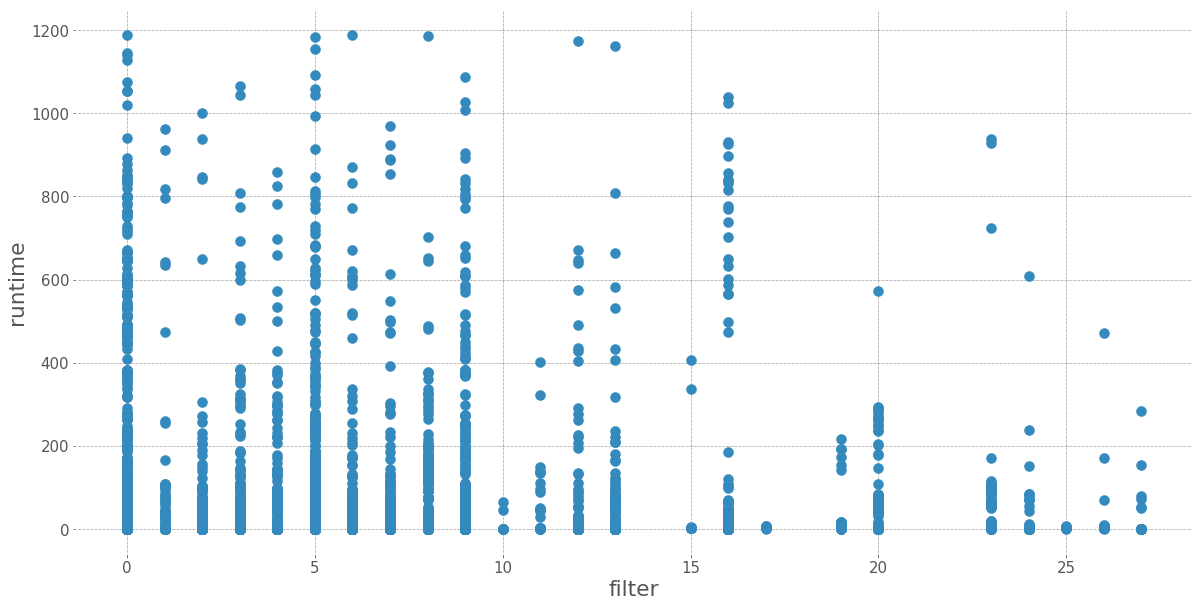

In [67]:
all_queries_with_runtime[SUCCESS ].plot(kind='scatter', x='filter', y='runtime', logy=False, figsize=(20,10), s=100)

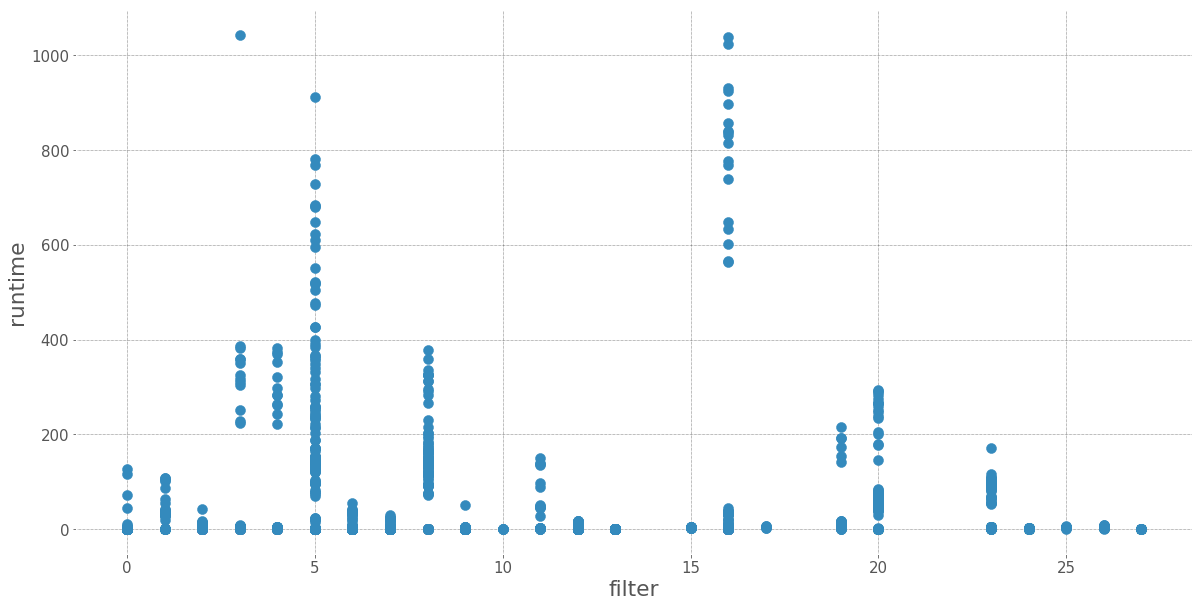

In [68]:
virtuoso = all_queries_with_runtime['sim'] == 3
all_queries_with_runtime[SUCCESS & virtuoso].plot(kind='scatter', x='filter', y='runtime', logy=False, figsize=(20,10), s=100)

In [69]:
FILLT5 = all_queries['filter'] < 5 
FILGE5 = all_queries['filter'] >= 5 

In [70]:
all_queries_with_runtime[SUCCESS & FILLT5]['runtime'].describe()

count    8343.000000
mean       23.047922
std        96.838937
min         0.003208
25%         0.006078
50%         0.074109
75%         0.908967
max      1187.794528
Name: runtime, dtype: float64

In [71]:
all_queries_with_runtime[SUCCESS & FILGE5]['runtime'].describe()

count    4715.000000
mean       44.629491
std       133.795745
min         0.004155
25%         0.052775
50%         0.868739
75%        14.493490
max      1188.436479
Name: runtime, dtype: float64

In [72]:
all_queries_with_runtime[SUCCESS].corr()

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
class,1.000000,0.626683,0.124497,0.209940,0.004755,0.165598,0.206755,0.276375,-0.011776,0.173215,0.153345,0.084123,-0.310395
runtime,0.626683,1.000000,0.078460,0.086791,0.014957,0.029223,0.063686,0.108168,0.004780,0.049735,0.044393,-0.015498,-0.134380
group,0.124497,0.078460,1.000000,0.417074,0.038607,0.090838,0.518323,0.210808,-0.016344,0.422568,0.165507,0.062621,0.116996
optional,0.209940,0.086791,0.417074,1.000000,0.151462,0.341309,0.675434,0.621339,0.307452,0.611611,0.404699,0.206801,0.172923
order,0.004755,0.014957,0.038607,0.151462,1.000000,0.049283,0.007902,0.041958,0.019846,0.047350,0.116650,0.057523,0.090651
filter_in,0.165598,0.029223,0.090838,0.341309,0.049283,1.000000,0.739258,0.500134,-0.033670,0.846092,0.931303,0.935267,0.165253
filter,0.206755,0.063686,0.518323,0.675434,0.007902,0.739258,1.000000,0.751747,-0.046365,0.946878,0.804705,0.589875,0.197647
count,0.276375,0.108168,0.210808,0.621339,0.041958,0.500134,0.751747,1.000000,-0.062271,0.636485,0.526739,0.245656,0.140191
graph,-0.011776,0.004780,-0.016344,0.307452,0.019846,-0.033670,-0.046365,-0.062271,1.000000,0.038731,-0.033752,-0.016243,-0.031400
triplePattern,0.173215,0.049735,0.422568,0.611611,0.047350,0.846092,0.946878,0.636485,0.038731,1.000000,0.920547,0.730955,0.193389


In [73]:
virtuoso = all_queries_with_runtime['sim'] == 3
all_queries_with_runtime[SUCCESS & virtuoso].corr()

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
class,1.000000,0.662878,0.283523,0.383767,0.112044,0.324366,0.374965,0.361131,-0.022611,0.372537,0.380235,0.249558,NaN
runtime,0.662878,1.000000,0.216999,0.179356,0.077687,0.060082,0.125217,0.169893,-0.010133,0.120921,0.125526,0.004335,NaN
group,0.283523,0.216999,1.000000,0.462446,0.048046,0.062163,0.535844,0.233606,-0.015157,0.423568,0.150594,0.038522,NaN
optional,0.383767,0.179356,0.462446,1.000000,0.186506,0.315485,0.706109,0.659705,0.251377,0.610867,0.418378,0.206225,NaN
order,0.112044,0.077687,0.048046,0.186506,1.000000,0.063003,0.033408,0.110214,0.028358,0.072572,0.147268,0.055975,NaN
filter_in,0.324366,0.060082,0.062163,0.315485,0.063003,1.000000,0.732518,0.463114,-0.027612,0.855324,0.943233,0.956326,NaN
filter,0.374965,0.125217,0.535844,0.706109,0.033408,0.732518,1.000000,0.729489,-0.042822,0.951341,0.807475,0.626080,NaN
count,0.361131,0.169893,0.233606,0.659705,0.110214,0.463114,0.729489,1.000000,-0.055147,0.622116,0.520420,0.265182,NaN
graph,-0.022611,-0.010133,-0.015157,0.251377,0.028358,-0.027612,-0.042822,-0.055147,1.000000,0.012830,-0.029747,-0.015670,NaN
triplePattern,0.372537,0.120921,0.423568,0.610867,0.072572,0.855324,0.951341,0.622116,0.012830,1.000000,0.925795,0.773583,NaN


In [74]:


def extract_rules_RuntimeRegression_NOENGINE(df, filename, maxdepth=2):
    print("[<1s, <10s, <100s, >=100s]")
    
    #FIT Decision Tree
    model = tree.DecisionTreeRegressor(max_depth=maxdepth)

    mask = df['class'] >= 2.5
    df = df[mask]
    
    print(df['class'].value_counts())
    
    X = df[df.columns[2:-1]].as_matrix()


    y = df['runtime'].as_matrix()
    model.fit(X,y)

    treedata = tree.export_graphviz(model, out_file=None, feature_names=df.columns[2:-1], filled=True, proportion=False) 
    graph = graphviz.Source(treedata) 
    graph.format = 'svg'
    graph.render('img/TreesAllSims/'+filename+"_RUNTIME_REGRESSION_NOENGINE", view=False)
    
    graph.format = 'pdf'
    graph.render('img/TreesAllSims/'+filename+"_RUNTIME_REGRESSION_NOENGINE", view=False)
    
    graph.format = 'png'
    graph.render('img/TreesAllSims/'+filename+"_RUNTIME_REGRESSION_NOENGINE", view=False)
    
    return graph, model

In [75]:
all_queries_with_runtime

,class,runtime,group,optional,order,filter_in,filter,count,graph,triplePattern,query,jsonSize,sim
xzaub,0,0.164710,0.0,3.0,0.0,0.0,1.0,0.0,1.0,9.0,1.0,1,0
xdm,3,0.055763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1,0
xzalo,5,52.323868,2.0,1.0,0.0,1.0,7.0,1.0,0.0,5.0,1.0,1,0
xjf,2,1200.000000,4.0,3.0,0.0,2.0,20.0,0.0,0.0,17.0,3.0,10,0
xyc,2,1200.000000,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,0
xzase,2,1200.000000,0.0,3.0,0.0,2.0,12.0,1.0,0.0,11.0,3.0,10,0
xnt,3,0.053037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0
xzady,2,1200.000000,0.0,1.0,0.0,14.0,23.0,1.0,0.0,33.0,9.0,100,0
xtt,3,0.113450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0
xut,6,517.668039,0.0,1.0,0.0,2.0,9.0,1.0,0.0,11.0,3.0,1,0


In [76]:
gr, t = extract_rules_RuntimeRegression_NOENGINE(all_queries_with_runtime, 'allqueries_d4', maxdepth=4)


[<1s, <10s, <100s, >=100s]
3    8726
4    1790
5    1649
6     893
Name: class, dtype: int64


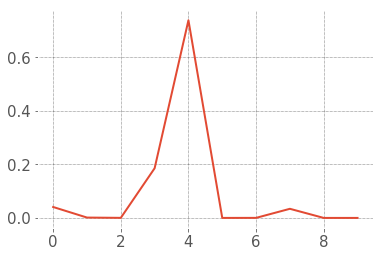

In [77]:
plt.plot(t.feature_importances_)

In [78]:
featurenames = all_queries_with_runtime.columns[2:-1]
featurenames

Index(['group', 'optional', 'order', 'filter_in', 'filter', 'count', 'graph',
       'triplePattern', 'query', 'jsonSize'],
      dtype='object')

In [79]:
df_importance = pd.DataFrame(t.feature_importances_, columns=['Feature Importance'], index=featurenames)

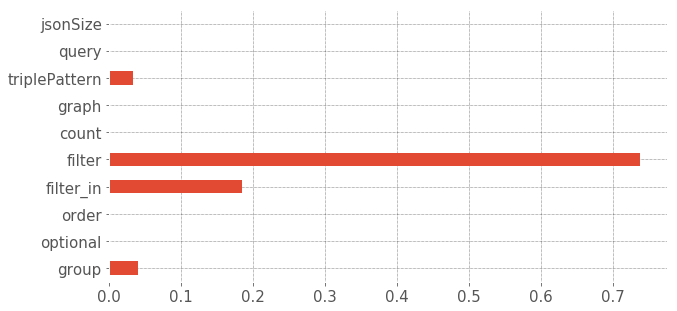

In [80]:
df_importance.plot(kind='barh', figsize=(10,5), legend=None)